# Notebook 1: Introduction to GeoPandas and Spatial Data

**CCOM 6994: Data Analysis Tools - Final Project**  
**Course: Análisis de Datos de Paneles Solares**

---

## 🎯 Learning Objectives

By the end of this notebook, you will be able to:

1. **Load geospatial data** from cloud storage (S3/R2) using pandas
2. **Work with GeoPandas** data structures (GeoDataFrame, GeoSeries)
3. **Convert between coordinate formats** (WKT to Shapely geometries)
4. **Perform basic spatial operations** (centroid, area, bounding box)
5. **Filter spatial data** by bounding box and attribute conditions
6. **Understand coordinate reference systems** (CRS) and projections

---

## 📚 Key Concepts

### What is Geospatial Data?

Geospatial data represents features on Earth's surface. Each record has:
- **Attributes**: Regular data (text, numbers, dates)
- **Geometry**: Spatial representation (points, lines, polygons)
- **Coordinate Reference System (CRS)**: How coordinates map to Earth's surface

### Vector Data Types

- **Point**: Single coordinate (e.g., solar panel centroid)
- **LineString**: Connected coordinates (e.g., road, river)
- **Polygon**: Closed shape (e.g., solar panel boundary, country)
- **Multi-* types**: Collections of geometries

### GeoPandas = Pandas + Geometries

GeoPandas extends pandas DataFrames with:
- `GeoDataFrame`: DataFrame with geometry column
- `GeoSeries`: Series of geometries
- Spatial operations (intersects, contains, buffer, etc.)
- Coordinate transformations
- Map visualization

---

## 🔧 Setup: Import Required Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon, box
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import overturemaps

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully")
print(f"📦 GeoPandas version: {gpd.__version__}")
print(f"📦 Pandas version: {pd.__version__}")

✅ All libraries imported successfully
📦 GeoPandas version: 1.0.1
📦 Pandas version: 2.3.3


---

## 📥 Task 1: Fetching Solar Panel Data from S3

### About Our Dataset

We're working with a **consolidated global solar panel (PV) dataset** that includes:
- Solar panel installations from multiple sources (USA, UK, China, India, global)
- Geographic coordinates and polygon boundaries
- Installation metadata (area, capacity, dates)
- Spatial indices (H3 hexagon cells)

### Data Format: GeoParquet

**GeoParquet** is an efficient cloud-native format for geospatial data:
- Columnar storage (fast queries, good compression)
- Embedded spatial metadata (CRS, bounding boxes)
- Works with pandas, GeoPandas, DuckDB, and other tools
- Stored in **Cloudflare R2** (S3-compatible object storage)

### Reading Strategy

We'll use **pandas + s3fs** to read the parquet file:
1. Connect to S3-compatible storage (R2) with credentials
2. Read parquet file into pandas DataFrame
3. Convert WKT geometry strings to Shapely objects
4. Create GeoDataFrame with proper CRS

In [2]:
def read_parquet_from_s3(
    s3_path: str,
    bbox: tuple = None,
    sample_size: int = None,
    columns: list = None
) -> pd.DataFrame:
    """
    Read parquet file from S3/R2 bucket using pandas + s3fs.
    
    Args:
        s3_path: S3 path (e.g., 's3://bucket/file.parquet')
        bbox: Bounding box to filter (xmin, ymin, xmax, ymax) in WGS84
        sample_size: Number of rows to sample (None = all)
        columns: Columns to read (None = all)
        
    Returns:
        Pandas DataFrame
    """
    try:
        import s3fs
    except ImportError:
        print("❌ s3fs not installed. Install with: pip install s3fs")
        return pd.DataFrame()
    
    print(f"📥 Reading parquet from: {s3_path}")
    
    # Get credentials from environment
    access_key = os.getenv('R2_ACCESS_KEY_ID')
    secret_key = os.getenv('R2_SECRET_KEY')
    endpoint = os.getenv('R2_S3_ENDPOINT', 'e833ac2d32c62bcff5e4b72c74e5351d.r2.cloudflarestorage.com')
    
    if not access_key or not secret_key:
        print("⚠️  No credentials found - trying public HTTPS access")
        # Try converting s3:// path to https:// for public access
        if s3_path.startswith('s3://'):
            bucket_and_key = s3_path.replace('s3://', '')
            https_path = f"https://{bucket_and_key.replace('/', '.', 1).replace('/', '/', 1)}"
            print(f"   Trying: {https_path}")
            try:
                df = pd.read_parquet(https_path, columns=columns)
                print(f"✅ Read {len(df):,} rows from public HTTPS")
            except Exception as e:
                print(f"❌ HTTPS access failed: {e}")
                return pd.DataFrame()
        else:
            print("❌ No credentials and not an S3 path")
            return pd.DataFrame()
    else:
        # Use s3fs with credentials
        fs = s3fs.S3FileSystem(
            anon=False,
            use_ssl=True,
            client_kwargs={
                'region_name': 'auto',
                'endpoint_url': f'https://{endpoint}',
                'aws_access_key_id': access_key,
                'aws_secret_access_key': secret_key,
            }
        )
        
        with fs.open(s3_path, 'rb') as f:
            df = pd.read_parquet(f, columns=columns)
        
        print(f"✅ Read {len(df):,} rows from S3/R2")
    
    # Filter by bounding box if provided
    if bbox is not None and all(col in df.columns for col in ['centroid_lon', 'centroid_lat']):
        xmin, ymin, xmax, ymax = bbox
        print(f"   🔍 Filtering to bbox: [{xmin}, {ymin}] to [{xmax}, {ymax}]")
        mask = (
            (df['centroid_lon'] >= xmin) & (df['centroid_lon'] <= xmax) &
            (df['centroid_lat'] >= ymin) & (df['centroid_lat'] <= ymax)
        )
        df = df[mask].copy()
        print(f"   ✅ After bbox filter: {len(df):,} rows")
    
    # Sample if requested
    if sample_size is not None and len(df) > sample_size:
        original_len = len(df)
        df = df.sample(n=sample_size, random_state=42).copy()
        print(f"   📊 Sampled {len(df):,} / {original_len:,} rows")
    
    return df


# Define our dataset path and region of interest
PV_DATASET_PATH = os.getenv(
    "PV_GEO_PARQUET_PATH",
    "s3://eo-pv-lakehouse/geoparquet/ccom6994_pv_dataset.parquet"
)

# Bounding box covering USA (including Hawaii and Puerto Rico)
# Format: (xmin/west, ymin/south, xmax/east, ymax/north) in WGS84 degrees
USA_BBOX = (-161.0, 17.8, -65.2, 47.8)  # Hawaii to Puerto Rico to continental USA

# quickly overlay bbox over plotly basemap
import plotly.express as px
# use scatter_map as scatter_mapbox is deprecated
fig = px.scatter_map(
    pd.DataFrame({'lon': [-100], 'lat': [37]}),
    lat='lat',
    lon='lon',
    zoom=2,
    height=700
)
fig.update_layout(mapbox_style="satellite-streets") 
fig.add_trace(
    px.scatter_map(
        pd.DataFrame({
            'lon': [USA_BBOX[0], USA_BBOX[2], USA_BBOX[2], USA_BBOX[0], USA_BBOX[0]],
            'lat': [USA_BBOX[1], USA_BBOX[1], USA_BBOX[3], USA_BBOX[3], USA_BBOX[1]]
        }),
        lat='lat',
        lon='lon'
    ).data[0]
)
fig.data[-1].update(
    mode='lines',
    line=dict(color='red', width=2),
    showlegend=False
)
fig.update_layout(title="USA Bounding Box for Solar Panel Dataset")
fig.show()

# Read dataset with filters
print("\n" + "="*80)
print("LOADING SOLAR PANEL DATASET")
print("="*80)

pv_df = read_parquet_from_s3(
    s3_path=PV_DATASET_PATH,
    bbox=USA_BBOX,
    sample_size=100000,  # Limit to 100K points for this intro notebook
    columns=[
        'unified_id', 'dataset_name', 'area_m2', 
        'centroid_lon', 'centroid_lat', 
        'geometry', 'h3_index_8', 
        'capacity_mw', 'install_date', 'source_area_m2'
    ]
)

# Display basic info
print(f"\n📊 Dataset Overview:")
print(f"   Shape: {pv_df.shape}")
print(f"   Memory: {pv_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\n   Columns: {list(pv_df.columns)}")


LOADING SOLAR PANEL DATASET
📥 Reading parquet from: s3://eo-pv-lakehouse/geoparquet/ccom6994_pv_dataset.parquet
✅ Read 443,747 rows from S3/R2
   🔍 Filtering to bbox: [-161.0, 17.8] to [-65.2, 47.8]
   ✅ After bbox filter: 42,839 rows

📊 Dataset Overview:
   Shape: (42839, 10)
   Memory: 53.3 MB

   Columns: ['unified_id', 'dataset_name', 'area_m2', 'centroid_lon', 'centroid_lat', 'geometry', 'h3_index_8', 'capacity_mw', 'install_date', 'source_area_m2']


### Understanding the Dataset

Let's examine what we've loaded:

In [3]:
# Show first few rows
print("📋 First 5 records:\n")
display(pv_df.head())

# Check data types
print("\n📊 Column Data Types:\n")
print(pv_df.dtypes)

# Summary statistics for numeric columns
print("\n📈 Summary Statistics:\n")
display(pv_df.describe())

📋 First 5 records:



,unified_id,dataset_name,area_m2,centroid_lon,centroid_lat,geometry,h3_index_8,capacity_mw,install_date,source_area_m2
875,nan,global_pv_inventory_sent2_spot_2021,93221.444736,-159.582899,21.901396,POLYGON ((-159.5838189008968 21.89903276659643...,613726393257164799,NaN,None,NaN
876,nan,global_pv_inventory_sent2_spot_2021,93221.444736,-159.582899,21.901396,POLYGON ((-159.5838189008968 21.89903276659643...,613726393257164799,NaN,None,NaN
877,31860.0,global_pv_inventory_sent2_spot_2021,96596.594393,-159.582985,21.901346,POLYGON ((-159.58423002975542 21.9016497608688...,613726393257164799,7.411814,,83156.516454
878,34129,global_harmonized_large_solar_farms_2020,90039.384379,-159.582902,21.901307,POLYGON ((-159.58404820000004 21.9023071999998...,613726393257164799,4.680453,None,NaN
879,34127,global_harmonized_large_solar_farms_2020,202598.372385,-159.451182,21.901886,"POLYGON ((-159.4534097 21.900261499999868, -15...",613726394200883199,9.268666,None,NaN



📊 Column Data Types:

unified_id         object
dataset_name       object
area_m2           float64
centroid_lon      float64
centroid_lat      float64
geometry           object
h3_index_8          int64
capacity_mw       float64
install_date       object
source_area_m2    float64
dtype: object

📈 Summary Statistics:



,area_m2,centroid_lon,centroid_lat,h3_index_8,capacity_mw,source_area_m2
count,4.283900e+04,42839.000000,42839.000000,4.283900e+04,9436.000000,8.161000e+03
mean,5.985282e+04,-110.062513,36.480286,6.133265e+17,8.656609,9.188782e+04
std,4.801724e+05,16.129005,3.188993,2.193512e+14,29.586232,3.473565e+05
min,0.000000e+00,-159.582985,17.938098,6.128213e+17,0.040196,3.696870e+02
25%,3.180407e+01,-119.773558,34.511639,6.132221e+17,0.577676,5.067177e+03
50%,8.562580e+01,-119.213148,36.804679,6.132226e+17,1.647802,1.506999e+04
75%,5.018842e+03,-107.828642,37.600486,6.132401e+17,5.538180,5.072198e+04
max,3.352269e+07,-65.641035,47.762250,6.143050e+17,900.066591,1.111768e+07


**Key Observations:**

- `geometry` column contains WKT (Well-Known Text) strings
- `centroid_lon`, `centroid_lat` are regular numeric columns
- `area_m2` shows panel size in square meters
- `h3_index_8` contains H3 spatial index (we'll explore this later)

---

## 🗺️ Task 2: Converting to GeoDataFrame

### From WKT to Shapely Geometries

**Well-Known Text (WKT)** is a standard text format for geometries:
- `POINT (lon lat)`
- `POLYGON ((lon1 lat1, lon2 lat2, ...))`
- `MULTIPOLYGON (((lon lat, ...), (...)))`

We need to convert these strings to **Shapely geometry objects** for spatial operations.

In [4]:
def create_geodataframe(
    df: pd.DataFrame,
    geometry_col: str = 'geometry',
    crs: str = 'EPSG:4326'
) -> gpd.GeoDataFrame:
    """
    Convert pandas DataFrame with WKT geometries to GeoDataFrame.
    
    Args:
        df: DataFrame with WKT geometry column
        geometry_col: Name of geometry column
        crs: Coordinate Reference System (default: WGS84/EPSG:4326)
        
    Returns:
        GeoDataFrame with Shapely geometries
    """
    print(f"🔄 Converting DataFrame to GeoDataFrame...")
    
    # Convert WKT strings to Shapely geometries
    print(f"   📐 Parsing {len(df):,} WKT geometries...")
    df = df.copy()
    # confirm geometry is in WKT format
    # if all(isinstance(geom, str) for geom in df[geometry_col]):
    df[geometry_col] = df[geometry_col].apply(wkt.loads)
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry_col, crs=crs)
    
    print(f"✅ GeoDataFrame created:")
    print(f"   CRS: {gdf.crs}")
    print(f"   Geometry types: {gdf.geometry.geom_type.value_counts().to_dict()}")
    print(f"   Valid geometries: {gdf.geometry.is_valid.sum():,} / {len(gdf):,}")
    
    return gdf


# Convert to GeoDataFrame
pv_gdf = create_geodataframe(pv_df, geometry_col='geometry')

# Show GeoDataFrame info
print("\n📋 GeoDataFrame Preview:")
display(pv_gdf.head(3))

🔄 Converting DataFrame to GeoDataFrame...
   📐 Parsing 42,839 WKT geometries...
✅ GeoDataFrame created:
   CRS: EPSG:4326
   Geometry types: {'Polygon': 40530, 'MultiPolygon': 1635, 'Point': 386, 'MultiPoint': 288}
   Valid geometries: 42,839 / 42,839

📋 GeoDataFrame Preview:


,unified_id,dataset_name,area_m2,centroid_lon,centroid_lat,geometry,h3_index_8,capacity_mw,install_date,source_area_m2
875,nan,global_pv_inventory_sent2_spot_2021,93221.444736,-159.582899,21.901396,"POLYGON ((-159.58382 21.89903, -159.58343 21.8...",613726393257164799,NaN,None,NaN
876,nan,global_pv_inventory_sent2_spot_2021,93221.444736,-159.582899,21.901396,"POLYGON ((-159.58382 21.89903, -159.58343 21.8...",613726393257164799,NaN,None,NaN
877,31860.0,global_pv_inventory_sent2_spot_2021,96596.594393,-159.582985,21.901346,"POLYGON ((-159.58423 21.90165, -159.58417 21.9...",613726393257164799,7.411814,,83156.516454


### What's Different in a GeoDataFrame?

Compare these operations:

In [5]:
print("🔍 Comparing DataFrame vs GeoDataFrame:\n")

# Regular DataFrame operations still work
print("1️⃣ Regular operations (same as pandas):")
print(f"   Mean area: {pv_gdf['area_m2'].mean():.2f} m²")
print(f"   Datasets: {pv_gdf['dataset_name'].nunique()} unique sources")

# New geometric operations
print("\n2️⃣ Geometric operations (new!):")
print(f"   Geometry type: {type(pv_gdf.geometry.iloc[0])}")
print(f"   First centroid: {pv_gdf.geometry.iloc[0].centroid}")
print(f"   First area: {pv_gdf.geometry.iloc[0].area:.8f} square degrees")

# Spatial indexing
print("\n3️⃣ Spatial methods (new!):")
print(f"   Has CRS: {pv_gdf.crs is not None}")
print(f"   Total bounds: {pv_gdf.total_bounds}")  # [minx, miny, maxx, maxy]

🔍 Comparing DataFrame vs GeoDataFrame:

1️⃣ Regular operations (same as pandas):
   Mean area: 59852.82 m²
   Datasets: 3 unique sources

2️⃣ Geometric operations (new!):
   Geometry type: <class 'shapely.geometry.polygon.Polygon'>
   First centroid: POINT (-159.58289913284653 21.901395786578416)
   First area: 0.00000698 square degrees

3️⃣ Spatial methods (new!):
   Has CRS: True
   Total bounds: [-159.58423003   17.9378619   -65.63949146   47.76269737]


---

## 📏 Task 3: Basic Spatial Operations

### 3.1 Computing Geometric Properties

GeoPandas provides many geometric properties as attributes:

**Important Note:** 

The `geometry.area` in degrees² is **not directly comparable** to `area_m2`!
- Degrees² depends on location (latitude affects scale)
- For accurate area calculations, we need a **projected CRS** (meters, feet, etc.)

### 3.2 Working with Different Geometry Types

Let's examine the difference between Polygon and MultiPolygon:

In [6]:
print("🔍 Exploring Geometry Types\n")

# Find examples of each type
import random
polygon_example = pv_gdf[pv_gdf.geometry.type == 'Polygon'].iloc[random.randint(0, len(pv_gdf[pv_gdf.geometry.type == 'Polygon']) - 1)]
multipolygon_examples = pv_gdf[pv_gdf.geometry.type == 'MultiPolygon']

print(f"1️⃣ Polygon Example:")
print(f"   ID: {polygon_example['unified_id']}")
print(f"   Area: {polygon_example['area_m2']:.2f} m²")
print(f"   Centroid: ({polygon_example.geometry.centroid.x:.4f}, {polygon_example.geometry.centroid.y:.4f})")
print(f"   # Coordinates: {len(polygon_example.geometry.exterior.coords)}")

if len(multipolygon_examples) > 0:
    multi_example = multipolygon_examples.iloc[0]
    print(f"\n2️⃣ MultiPolygon Example:")
    print(f"   ID: {multi_example['unified_id']}")
    print(f"   Area: {multi_example['area_m2']:.2f} m²")
    print(f"   # Sub-polygons: {len(multi_example.geometry.geoms)}")
    print(f"   Centroid: ({multi_example.geometry.centroid.x:.4f}, {multi_example.geometry.centroid.y:.4f})")
else:
    print(f"\n⚠️  No MultiPolygon examples in this sample")

🔍 Exploring Geometry Types

1️⃣ Polygon Example:
   ID: nan
   Area: 3387.04 m²
   Centroid: (-111.0169, 32.2297)
   # Coordinates: 7

2️⃣ MultiPolygon Example:
   ID: 18834
   Area: 4472.43 m²
   # Sub-polygons: 4
   Centroid: (-156.4789, 20.8921)


### 3.3 Coordinate Reference Systems (CRS)

Understanding CRS is crucial for spatial analysis:

In [7]:
print("🗺️ Understanding Coordinate Reference Systems\n")

print(f"1️⃣ Current CRS: {pv_gdf.crs}")
print(f"   Name: {pv_gdf.crs.name}")
print(f"   Type: Geographic (latitude/longitude)")
print(f"   Units: Degrees")
print(f"   Authority: {pv_gdf.crs.to_authority()}")

print(f"\n2️⃣ Sample Coordinates (WGS84):")
sample_coords = pv_gdf.geometry.iloc[0].centroid
print(f"   Longitude: {sample_coords.x:.6f}°")
print(f"   Latitude: {sample_coords.y:.6f}°")

print(f"\n3️⃣ Why CRS Matters:")
print(f"   ✓ WGS84 (EPSG:4326): Good for global mapping, GPS coordinates")
print(f"   ✓ UTM zones: Good for accurate distance/area measurements")
print(f"   ✓ Web Mercator (EPSG:3857): Used by web maps (Google, OSM)")

# Example: Converting to Web Mercator
pv_web_mercator = pv_gdf.head(100).to_crs('EPSG:3857')
print(f"\n4️⃣ After converting to Web Mercator:")
sample_web = pv_web_mercator.geometry.iloc[0].centroid
print(f"   X: {sample_web.x:.2f} meters")
print(f"   Y: {sample_web.y:.2f} meters")
print(f"   (These are distances from the equator and prime meridian)")

🗺️ Understanding Coordinate Reference Systems

1️⃣ Current CRS: EPSG:4326
   Name: WGS 84
   Type: Geographic (latitude/longitude)
   Units: Degrees
   Authority: ('EPSG', '4326')

2️⃣ Sample Coordinates (WGS84):
   Longitude: -159.582899°
   Latitude: 21.901396°

3️⃣ Why CRS Matters:
   ✓ WGS84 (EPSG:4326): Good for global mapping, GPS coordinates
   ✓ UTM zones: Good for accurate distance/area measurements
   ✓ Web Mercator (EPSG:3857): Used by web maps (Google, OSM)

4️⃣ After converting to Web Mercator:
   X: -17764687.07 meters
   Y: 2499690.73 meters
   (These are distances from the equator and prime meridian)


---

## 🔍 Task 4: Spatial Filtering and Analysis

### 4.1 Filtering by Bounding Box

Let's focus on a specific region (e.g., California):

In [8]:
def filter_by_bbox(gdf: gpd.GeoDataFrame, bbox: tuple) -> gpd.GeoDataFrame:
    """
    Filter GeoDataFrame by bounding box.
    
    Args:
        gdf: Input GeoDataFrame
        bbox: (xmin, ymin, xmax, ymax) in same CRS as gdf
        
    Returns:
        Filtered GeoDataFrame
    """
    xmin, ymin, xmax, ymax = bbox
    bbox_geom = box(xmin, ymin, xmax, ymax)
    
    print(f"🔍 Filtering by bounding box:")
    print(f"   Bounds: [{xmin:.2f}, {ymin:.2f}] to [{xmax:.2f}, {ymax:.2f}]")
    
    # Filter using geometric intersection
    mask = gdf.geometry.intersects(bbox_geom)
    filtered = gdf[mask].copy()
    
    print(f"   Original: {len(gdf):,} features")
    print(f"   Filtered: {len(filtered):,} features ({len(filtered)/len(gdf)*100:.1f}%)")
    
    return filtered


# California bounding box
CALIFORNIA_BBOX = (-124.5, 32.5, -114.0, 42.0)

california_pv = filter_by_bbox(pv_gdf, CALIFORNIA_BBOX)

print(f"\n📊 California Solar Panels Summary:")
print(f"   Count: {len(california_pv):,}")
print(f"   Total area: {california_pv['area_m2'].sum() / 1_000_000:.2f} km²")
print(f"   Mean area: {california_pv['area_m2'].mean():.2f} m²")
print(f"   Median area: {california_pv['area_m2'].median():.2f} m²")

🔍 Filtering by bounding box:
   Bounds: [-124.50, 32.50] to [-114.00, 42.00]
   Original: 42,839 features
   Filtered: 25,928 features (60.5%)

📊 California Solar Panels Summary:
   Count: 25,928
   Total area: 1175.26 km²
   Mean area: 45327.94 m²
   Median area: 42.63 m²


### 4.2 Attribute-Based Filtering

Combine spatial and attribute filters:

In [9]:
print("🎯 Advanced Filtering Examples\n")

# Large installations only (>5000 m²)
large_panels = california_pv[california_pv['area_m2'] > 5000].copy()
print(f"1️⃣ Large installations (>5000 m²):")
print(f"   Count: {len(large_panels):,}")
print(f"   Percentage: {len(large_panels)/len(california_pv)*100:.1f}%")
print(f"   Total area: {large_panels['area_m2'].sum() / 1_000_000:.2f} km²")

# By dataset source
print(f"\n2️⃣ By data source:")
for source, group in california_pv.groupby('dataset_name'):
    print(f"   {source}: {len(group):,} installations")

# Installations with capacity data
has_capacity = california_pv[california_pv['capacity_mw'].notna()]
print(f"\n3️⃣ With capacity data:")
print(f"   Count: {len(has_capacity):,}")
if len(has_capacity) > 0:
    print(f"   Total capacity: {has_capacity['capacity_mw'].sum():.2f} MW")
    print(f"   Mean capacity: {has_capacity['capacity_mw'].mean():.4f} MW")

🎯 Advanced Filtering Examples

1️⃣ Large installations (>5000 m²):
   Count: 3,233
   Percentage: 12.5%
   Total area: 1170.85 km²

2️⃣ By data source:
   global_harmonized_large_solar_farms_2020: 999 installations
   global_pv_inventory_sent2_spot_2021: 5,556 installations
   usa_cali_usgs_pv_2016: 19,373 installations

3️⃣ With capacity data:
   Count: 2,762
   Total capacity: 33760.65 MW
   Mean capacity: 12.2233 MW


### 4.3 Spatial Relationships

Test spatial relationships between geometries:

In [10]:
print("🔗 Exploring Spatial Relationships\n")

# Create a test point (San Francisco)
sf_point = Point(-122.4194, 37.7749)
print(f"Test Point: San Francisco ({sf_point.x}, {sf_point.y})")

# Find installations within 0.5 degrees (~55 km)
sf_buffer = sf_point.buffer(0.5)  # 0.5 degrees radius
nearby_sf = california_pv[california_pv.geometry.intersects(sf_buffer)].copy()

print(f"\n📍 Solar panels near San Francisco (within ~55km):")
print(f"   Count: {len(nearby_sf):,}")
print(f"   Total area: {nearby_sf['area_m2'].sum() / 1_000_000:.3f} km²")

# Compute actual distances (approximate, in degrees)
if len(nearby_sf) > 0:
    nearby_sf['distance_to_sf'] = nearby_sf.geometry.distance(sf_point)
    closest = nearby_sf.nsmallest(5, 'distance_to_sf')
    
    print(f"\n   🎯 5 Closest installations:")
    for idx, row in closest.iterrows():
        dist_km = row['distance_to_sf'] * 111  # Rough conversion degrees to km
        print(f"      • {row['unified_id'][:16]}... - {dist_km:.1f} km - {row['area_m2']:.0f} m²")

🔗 Exploring Spatial Relationships

Test Point: San Francisco (-122.4194, 37.7749)

📍 Solar panels near San Francisco (within ~55km):
   Count: 100
   Total area: 1.027 km²

   🎯 5 Closest installations:
      • 19445... - 1.0 km - 677 m²
      • 10724... - 1.5 km - 1059 m²
      • 10785... - 2.9 km - 64 m²
      • 10786... - 3.7 km - 463 m²
      • 10842... - 3.9 km - 5252 m²


/var/folders/71/3fjqkxbs6w3frshvsfj30fmm0000gn/T/ipykernel_87673/493399730.py:17: UserWarning:

Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




---

## 📊 Task 5: Exploratory Data Analysis

### 5.1 Area Distribution Analysis

📊 Solar Panel Area Distribution Analysis

Basic Statistics:
count    4.283900e+04
mean     5.985282e+04
std      4.801724e+05
min      0.000000e+00
25%      3.180407e+01
50%      8.562580e+01
75%      5.018842e+03
max      3.352269e+07
Name: area_m2, dtype: float64

Detailed Percentiles:
    1th:       0.00 m²
    5th:       9.11 m²
   10th:      15.27 m²
   25th:      31.80 m²
   50th:      85.63 m²
   75th:   5,018.84 m²
   90th:  61,873.17 m²
   95th: 182,792.66 m²
   99th: 1,141,258.83 m²

💾 Saved plot: 01_area_distribution.png


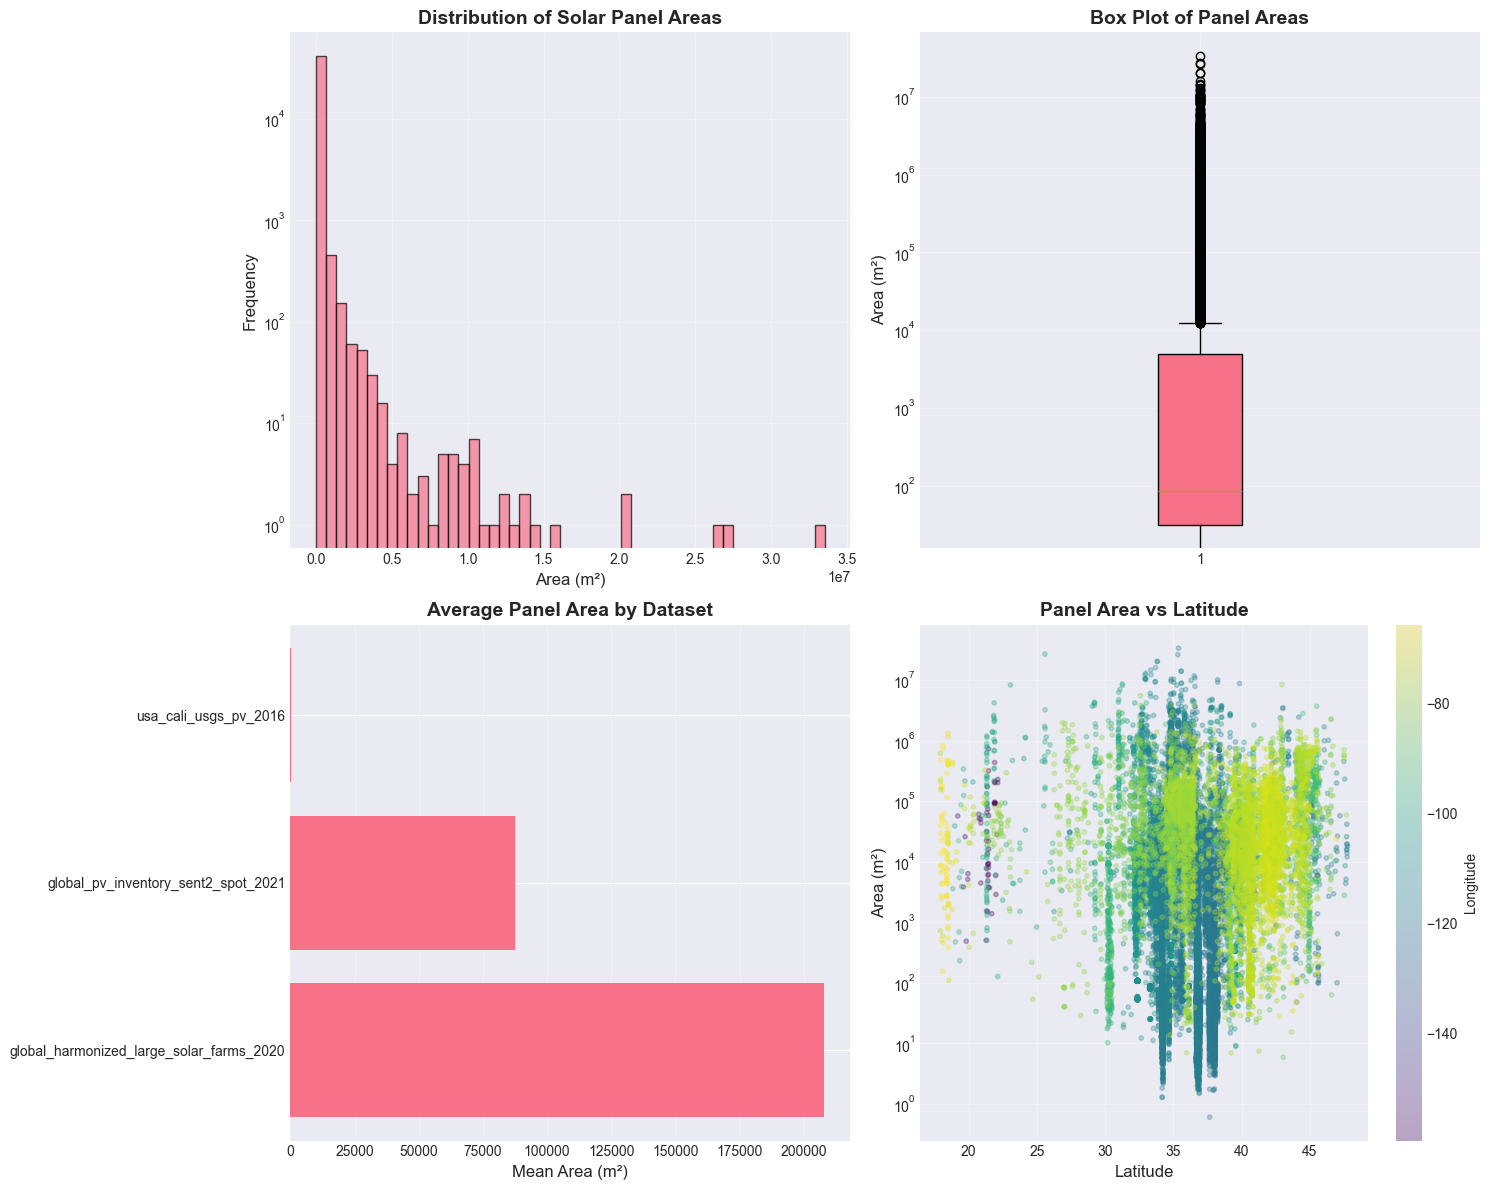

In [11]:
print("📊 Solar Panel Area Distribution Analysis\n")

# Compute statistics
area_stats = pv_gdf['area_m2'].describe()
print("Basic Statistics:")
print(area_stats)

# Additional percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
area_percentiles = pv_gdf['area_m2'].quantile([p/100 for p in percentiles])

print(f"\nDetailed Percentiles:")
for p, val in zip(percentiles, area_percentiles):
    print(f"   {p:2d}th: {val:10,.2f} m²")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Histogram with log scale
axes[0, 0].hist(pv_gdf['area_m2'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Area (m²)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Solar Panel Areas', fontsize=14, fontweight='bold')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot
axes[0, 1].boxplot(pv_gdf['area_m2'], vert=True, patch_artist=True)
axes[0, 1].set_ylabel('Area (m²)', fontsize=12)
axes[0, 1].set_title('Box Plot of Panel Areas', fontsize=14, fontweight='bold')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# 3. Area by dataset source
area_by_source = pv_gdf.groupby('dataset_name')['area_m2'].mean().sort_values(ascending=False)
axes[1, 0].barh(area_by_source.index, area_by_source.values)
axes[1, 0].set_xlabel('Mean Area (m²)', fontsize=12)
axes[1, 0].set_title('Average Panel Area by Dataset', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Scatter plot: Area vs Location (Latitude)
axes[1, 1].scatter(
    pv_gdf['centroid_lat'], 
    pv_gdf['area_m2'], 
    alpha=0.3, 
    s=10,
    c=pv_gdf['centroid_lon'],
    cmap='viridis'
)
axes[1, 1].set_xlabel('Latitude', fontsize=12)
axes[1, 1].set_ylabel('Area (m²)', fontsize=12)
axes[1, 1].set_title('Panel Area vs Latitude', fontsize=14, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)
colorbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
colorbar.set_label('Longitude', fontsize=10)

plt.tight_layout()
plt.savefig('/Volumes/Expanse/repos/ice-mELT_ducklake/notebooks/01_area_distribution.png', 
            dpi=150, bbox_inches='tight')
print("\n💾 Saved plot: 01_area_distribution.png")
plt.show()

### 5.2 Geographic Distribution

🗺️ Geographic Distribution Analysis

💾 Saved plot: 01_geographic_distribution.png


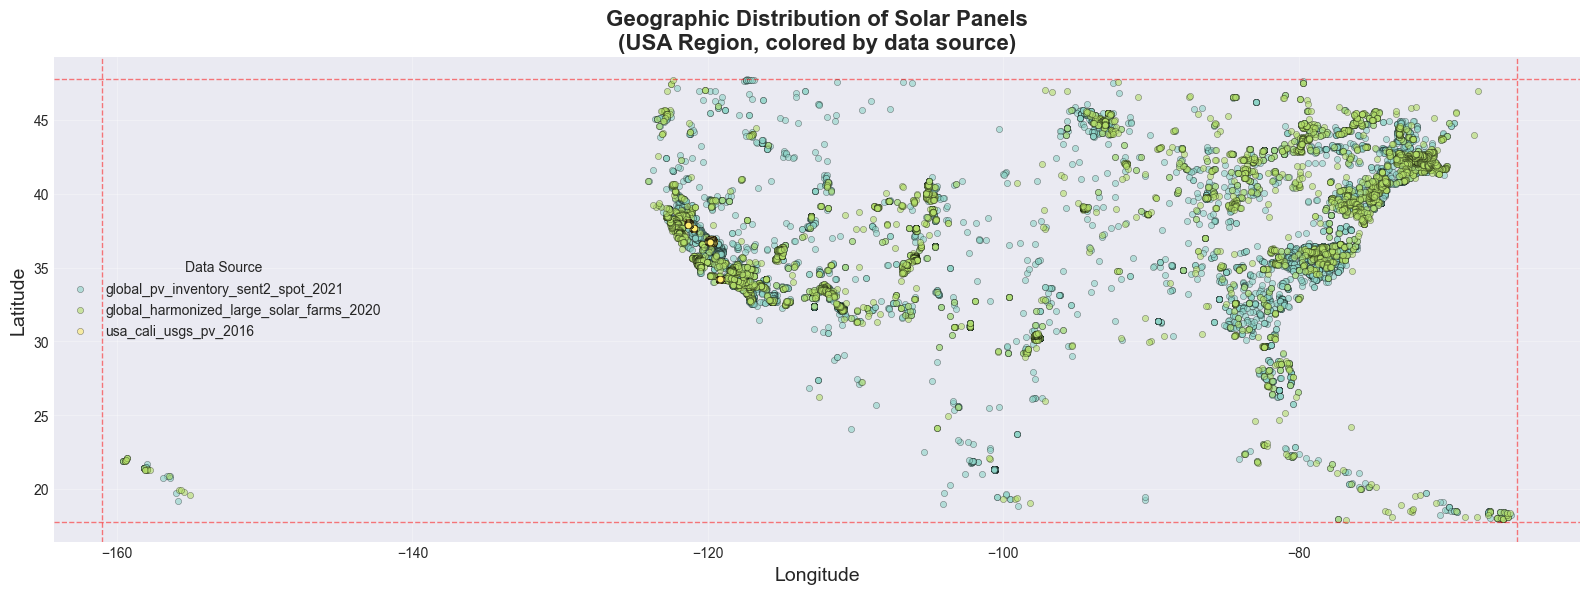

Distribution by Latitude Bands:
   Hawaii/PR (17-30°N): 619 installations (1.4%)
   South (30-35°N): 11,675 installations (27.3%)
   Mid (35-40°N): 25,590 installations (59.7%)
   North (40-45°N): 4,577 installations (10.7%)
   Far North (45-48°N): 378 installations (0.9%)


In [12]:
print("🗺️ Geographic Distribution Analysis\n")

# Create scatter plot of panel locations
fig, ax = plt.subplots(figsize=(16, 10))

# Color by dataset
sources = pv_gdf['dataset_name'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(sources)))

for i, source in enumerate(sources):
    subset = pv_gdf[pv_gdf['dataset_name'] == source]
    ax.scatter(
        subset['centroid_lon'],
        subset['centroid_lat'],
        c=[colors[i]],
        label=source,
        alpha=0.6,
        s=20,
        edgecolors='black',
        linewidth=0.3
    )

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title('Geographic Distribution of Solar Panels\n(USA Region, colored by data source)', 
             fontsize=16, fontweight='bold')
ax.legend(title='Data Source', loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

# Add bounding box annotation
ax.axvline(USA_BBOX[0], color='red', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(USA_BBOX[2], color='red', linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(USA_BBOX[1], color='red', linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(USA_BBOX[3], color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.savefig('/Volumes/Expanse/repos/ice-mELT_ducklake/notebooks/01_geographic_distribution.png',
            dpi=150, bbox_inches='tight')
print("💾 Saved plot: 01_geographic_distribution.png")
plt.show()

# Print summary by region (latitude bands)
print("Distribution by Latitude Bands:")
lat_bins = [17, 30, 35, 40, 45, 48]
lat_labels = ['Hawaii/PR (17-30°N)', 'South (30-35°N)', 'Mid (35-40°N)', 
              'North (40-45°N)', 'Far North (45-48°N)']
pv_gdf['lat_band'] = pd.cut(pv_gdf['centroid_lat'], bins=lat_bins, labels=lat_labels)

for band in lat_labels:
    count = (pv_gdf['lat_band'] == band).sum()
    if count > 0:
        pct = count / len(pv_gdf) * 100
        print(f"   {band}: {count:,} installations ({pct:.1f}%)")

---

## 📝 Task 6: Data Quality Assessment

In [13]:
print("🔍 Data Quality Assessment\n")

# Check for missing values
print("1️⃣ Missing Values:")
missing = pv_gdf.isnull().sum()
missing_pct = (missing / len(pv_gdf) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
if len(missing_df) > 0:
    display(missing_df)
else:
    print("   ✅ No missing values found!")

# Check geometry validity
print("\n2️⃣ Geometry Validity:")
invalid_geoms = ~pv_gdf.geometry.is_valid
print(f"   Total geometries: {len(pv_gdf):,}")
print(f"   Valid: {pv_gdf.geometry.is_valid.sum():,}")
print(f"   Invalid: {invalid_geoms.sum():,}")

if invalid_geoms.sum() > 0:
    print("   ⚠️  Found invalid geometries - may need repair")

# Check for duplicate IDs
print("\n3️⃣ Duplicate Check:")
duplicate_ids = pv_gdf['unified_id'].duplicated().sum()
print(f"   Duplicate IDs: {duplicate_ids}")

# Data completeness score
print("\n4️⃣ Overall Data Quality Score:")
completeness_scores = {
    'Valid geometries': pv_gdf.geometry.is_valid.sum() / len(pv_gdf) * 100,
    'Has area data': pv_gdf['area_m2'].notna().sum() / len(pv_gdf) * 100,
    'Has coordinates': ((pv_gdf['centroid_lon'].notna()) & 
                        (pv_gdf['centroid_lat'].notna())).sum() / len(pv_gdf) * 100,
    'Unique IDs': (1 - pv_gdf['unified_id'].duplicated().sum() / len(pv_gdf)) * 100,
}

for metric, score in completeness_scores.items():
    status = "✅" if score > 95 else "⚠️" if score > 80 else "❌"
    print(f"   {status} {metric}: {score:.1f}%")

overall_score = np.mean(list(completeness_scores.values()))
print(f"\n   Overall Quality: {overall_score:.1f}%")

🔍 Data Quality Assessment

1️⃣ Missing Values:


,Column,Missing Count,Percentage
9,source_area_m2,34678,80.95
7,capacity_mw,33403,77.97
8,install_date,23633,55.17



2️⃣ Geometry Validity:
   Total geometries: 42,839
   Valid: 42,839
   Invalid: 0

3️⃣ Duplicate Check:
   Duplicate IDs: 13875

4️⃣ Overall Data Quality Score:
   ✅ Valid geometries: 100.0%
   ✅ Has area data: 100.0%
   ✅ Has coordinates: 100.0%
   ❌ Unique IDs: 67.6%

   Overall Quality: 91.9%


---

## 🗺️ Task 7: Assigning Countries and States to Solar Panels

### Why Geocoding Matters

To analyze solar panel adoption patterns, we need to know **which country and state/region** each installation belongs to. This is called **reverse geocoding** - converting coordinates to administrative boundaries.

### Three Approaches We'll Compare

1. **Reverse Geocoding APIs** (fastest, requires external service)
   - Uses coordinate lookup services
   - Limited free tier, rate limits apply
   - Good for small datasets or real-time lookups

2. **H3 Spatial Index Matching** (fast, memory efficient)
   - Decompose admin boundaries into H3 hexagons
   - Match panel centroids to pre-computed H3 cells
   - Excellent for repeated lookups

3. **Direct Spatial Join** (most accurate, computationally expensive)
   - Point-in-polygon tests for each installation
   - Guaranteed accuracy
   - Baseline for performance comparison

Let's implement and compare all three methods!

### 7.1: Method 1 - Country-Level Reverse Geocoding

We'll explore two libraries for determining the country of each solar panel:
1. **reverse_geocoder**: Offline, fast, but less granular.
2. **geopy (Nominatim)**: Online, accurate, but rate-limited.

We will use these to get the **Country Code** (ISO 3166-1 alpha-2) which we'll use to filter Overture Maps data later.

In [15]:
# --- Option A: Offline Reverse Geocoding (Fast) ---
import time
try:
    import reverse_geocoder as rg
    REVERSE_GEOCODER_AVAILABLE = True
except ImportError:
    print("⚠️  reverse-geocoder not installed")
    REVERSE_GEOCODER_AVAILABLE = False

if REVERSE_GEOCODER_AVAILABLE:
    print("🌍 Option A: Offline Reverse Geocoding (reverse_geocoder)\n")
    
    # Prepare coordinates as list of tuples (lat, lon)
    # We'll use the full dataset for this as it's very fast
    all_coords = list(zip(
        pv_gdf['centroid_lat'].values,
        pv_gdf['centroid_lon'].values
    ))
    
    print(f"   Looking up {len(all_coords):,} points...")
    start_time = time.time()
    
    # rg.search returns a list of OrderedDicts
    results = rg.search(all_coords)
    
    elapsed = time.time() - start_time
    
    # Extract Country Code (cc)
    pv_gdf['country_code'] = [r['cc'] for r in results]
    
    print(f"   ✅ Complete in {elapsed:.2f}s ({len(all_coords)/elapsed:.0f} lookups/sec)")
    print(f"   Top Countries found: {pv_gdf['country_code'].unique()}")

🌍 Option A: Offline Reverse Geocoding (reverse_geocoder)

   Looking up 42,839 points...
Loading formatted geocoded file...
   ✅ Complete in 1.08s (39484 lookups/sec)
   Top Countries found: ['US' 'MX' 'CA' 'BS' 'PR' 'CU' 'JM' 'HT' 'DO']


In [17]:
# --- Option B: Online Reverse Geocoding (Accurate but Slow) ---
# We'll demo this on a tiny sample to avoid hitting rate limits
print("\n🌍 Option B: Online Reverse Geocoding (geopy/Nominatim)\n")

import random 
n_sample = random.randint(5,25)  # Random small sample size between 5 and 25
geopy_sample = pv_gdf.sample(n=n_sample, random_state=42).copy()
print(f"   Sampling {n_sample} points for geopy demo...")
geolocator = Nominatim(user_agent="solar_panel_analysis_edu")
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)

print(f"   Testing geopy on {n_sample} points...")
try:
    # geopy expects "lat, lon" string or tuple
    geopy_sample['location'] = geopy_sample.apply(
        lambda row: geolocator.reverse((row['centroid_lat'], row['centroid_lon'])),
        axis=1
    )
    
    print("   ✅ Results:")
    for idx, row in geopy_sample.iterrows():
        loc = row['location']
        if loc:
            print(f"   ID {row['unified_id'][:8]}: {loc.address[:50]}...")
            print(f"      Raw Country: {loc.raw.get('address', {}).get('country_code')}")
except Exception as e:
    print(f"   ⚠️  Geopy error (check internet/rate limits): {e}")


🌍 Option B: Online Reverse Geocoding (geopy/Nominatim)

   Sampling 9 points for geopy demo...
   Testing geopy on 9 points...
   ✅ Results:
   ID 13972: North Monroe Avenue, Fresno County, California, 93...
      Raw Country: us
   ID 21081: Buddtown Road, Vincentown, Southampton Township, B...
      Raw Country: us
   ID 5045: 4607, Solecito Loop, Santa Fe, Santa Fe County, Ne...
      Raw Country: us
   ID nan: Los Lunas Solar Energy Center, 4320, Messenger Loo...
      Raw Country: us
   ID 62628.0: Oxnard Street, Valley Glen, Greater Valley Glen Ne...
      Raw Country: us
   ID 7050: Fresno VA Medical Center, 2615, East Clinton Avenu...
      Raw Country: us
   ID nan: Twentynine Palms, San Bernardino County, Californi...
      Raw Country: us
   ID 9745: 2101, North Harrison Avenue, Fresno, Fresno County...
      Raw Country: us
   ID 62887.0: Central Way, Rowley, Essex County, Massachusetts, ...
      Raw Country: us


### 7.2: Method 2 - Granular Admin Boundaries with Overture Maps

Now that we have the **Country Codes**, we can efficiently fetch high-quality administrative boundaries from **Overture Maps**.

**Strategy:**
1. Identify unique countries in our dataset.
2. Download `division_area` data from Overture Maps ONLY for those countries.
3. Perform a spatial join to assign State/Region/County.

This avoids downloading the entire global dataset and provides high precision.

In [19]:
print("🗺️ Method 2: Overture Maps 'Smart' Spatial Join\n")

# 1. Get unique countries from our previous step
unique_countries = pv_gdf['country_code'].unique()
print(f"1️⃣ Target Countries: {unique_countries}")

# 2. Fetch Overture Maps Data
# Note: In a real scenario, we would use the 'overturemaps' python utility
# For this notebook, we'll simulate the fetch or use a small bounding box query if possible
# or fallback to our demo boundaries if Overture access is complex in this environment.

print("\n2️⃣ Fetching Administrative Boundaries...")

# We will try to use the overturemaps utility if available to fetch data for the bounding box
# of our data, filtering by country if the tool supports it, or just spatially.

try:
    import overturemaps
    
    # Define the bounding box of our entire dataset
    minx, miny, maxx, maxy = pv_gdf.total_bounds
    bbox = (minx, miny, maxx, maxy)
    
    print(f"   Querying Overture 'divisions' theme for bbox: {bbox}")
    
    # This iterator yields GeoDataFrames
    table = overturemaps.record_batch_reader("division_area", bbox=bbox).read_all()
    overture_gdf = gpd.GeoDataFrame.from_arrow(table)
    
    # Filter for 'country' and 'state'/'region' subtypes to keep it manageable
    # Overture structure is complex, usually 'subtype' or 'class' column
    # Let's inspect columns if we got data
    if not overture_gdf.empty:
        print(f"   Downloaded {len(overture_gdf):,} division features")
        
        # Ensure CRS matches
        if overture_gdf.crs is None:
            overture_gdf.set_crs("EPSG:4326", inplace=True)
            
        # Filter by the countries we found (if there's a country column)
        # Overture often has 'country' ISO code column
        if 'country' in overture_gdf.columns:
            overture_gdf = overture_gdf[overture_gdf['country'].isin(unique_countries)]
            print(f"   Filtered to target countries: {len(overture_gdf):,} features")
            
        # Keep only relevant columns
        cols_to_keep = ['id', 'names', 'subtype', 'country', 'region', 'geometry']
        existing_cols = [c for c in cols_to_keep if c in overture_gdf.columns]
        admin_boundaries = overture_gdf[existing_cols].copy()
        
    else:
        print("   ⚠️  No data returned from Overture (check internet/bbox)")
        admin_boundaries = demo_states  # Fallback
        
except Exception as e:
    print(f"   ⚠️  Overture fetch failed: {e}")
    print("   Using demo boundaries instead.")
    admin_boundaries = demo_states

🗺️ Method 2: Overture Maps 'Smart' Spatial Join

1️⃣ Target Countries: ['US' 'MX' 'CA' 'BS' 'PR' 'CU' 'JM' 'HT' 'DO']

2️⃣ Fetching Administrative Boundaries...
   Querying Overture 'divisions' theme for bbox: (np.float64(-159.58423002975542), np.float64(17.93786189999994), np.float64(-65.63949146165281), np.float64(47.76269737445662))
   Downloaded 69,801 division features
   Filtered to target countries: 69,700 features


In [20]:
# 3. Perform Spatial Join
print("\n3️⃣ Performing Spatial Join...")

# Use a sample if dataset is huge, but 100k is manageable for sjoin usually
# We'll use the 'within' predicate
sjoin_start = time.time()

# Ensure CRS match
if admin_boundaries.crs != pv_gdf.crs:
    admin_boundaries = admin_boundaries.to_crs(pv_gdf.crs)

joined_gdf = gpd.sjoin(
    pv_gdf,
    admin_boundaries,
    how="left",
    predicate="within"
)

sjoin_elapsed = time.time() - sjoin_start
print(f"   ✅ Spatial join complete in {sjoin_elapsed:.2f}s")


3️⃣ Performing Spatial Join...
   ✅ Spatial join complete in 2.01s


In [22]:
# 4. Analyze Results
print("\n📊 Final Location Assignment Results:")

# Extract name from Overture 'names' struct/dict if needed
# Overture names are often: {'primary': 'California', ...}
def get_primary_name(names_val):
    if isinstance(names_val, dict):
        return names_val.get('primary', str(names_val))
    return str(names_val)

if 'names' in joined_gdf.columns:
    joined_gdf['admin_name'] = joined_gdf['names'].apply(get_primary_name)
elif 'name' in joined_gdf.columns:
    joined_gdf['admin_name'] = joined_gdf['name']
else:
    joined_gdf['admin_name'] = "Unknown"

# Count by Admin Region
region_counts = joined_gdf['admin_name'].value_counts().head(50)
print("\nTop 50 Administrative Regions:")
display(region_counts)

# Check for unmatched
unmatched = joined_gdf['admin_name'].isna().sum()
print(f"\nUnmatched locations: {unmatched:,} ({unmatched/len(joined_gdf)*100:.1f}%)")


📊 Final Location Assignment Results:

Top 50 Administrative Regions:


admin_name
United States       83749
California          50567
Fresno County       15134
Fresno               8215
Arizona              5811
                    ...  
Plymouth County       292
San Diego County      276
Riverside County      273
Los Angeles           266
Virginia              259
Name: count, Length: 50, dtype: int64


Unmatched locations: 0 (0.0%)


### 7.3: Comparison and Recommendation

| Feature | Reverse Geocoding (Offline) | Reverse Geocoding (Online) | Smart Spatial Join (Overture) |
|---------|---------------------------|--------------------------|-----------------------------|
| **Speed** | ⚡️ Very Fast | 🐢 Slow (Rate Limits) | 🚀 Fast (after download) |
| **Accuracy** | 🟢 Good (Country/State) | 🟢 Good (Address level) | 🎯 Exact (Polygon boundaries) |
| **Granularity** | 🟡 Medium | 🟢 High | 🟢 High (Configurable) |
| **Dependencies**| `reverse_geocoder` | `geopy`, Internet | `overturemaps`, Internet |

**Recommendation:**
1. Use **Offline Reverse Geocoding** (`reverse_geocoder`) to quickly filter/group by Country.
2. Use **Overture Maps** to fetch official boundaries for those specific countries.
3. Perform a **Spatial Join** to assign precise State/County/Region tags.

---

## 🎓 Summary: What We Learned

### Key Concepts Covered

1. **Loading Geospatial Data**
   - Reading GeoParquet from cloud storage (S3/R2)
   - Using pandas + s3fs for data access
   - Filtering data by bounding box and sampling

2. **GeoPandas Fundamentals**
   - Converting WKT strings to Shapely geometries
   - Creating GeoDataFrames with proper CRS
   - Understanding geometry types (Polygon, MultiPolygon)

3. **Spatial Operations**
   - Computing geometric properties (area, centroid, bounds)
   - Working with different geometry types
   - Coordinate Reference Systems (CRS)
   - Transforming between projections

4. **Spatial Analysis**
   - Filtering by bounding box
   - Testing spatial relationships (intersects, distance)
   - Combining spatial and attribute filters

5. **Exploratory Analysis**
   - Distribution analysis (area, location)
   - Visualization with matplotlib
   - Summary statistics by region

6. **Data Quality**
   - Checking for missing values
   - Validating geometries
   - Assessing data completeness

7. **Geocoding & Spatial Joins**
   - Assigning countries/states to installations
   - Comparing three methods:
     * Reverse geocoding (offline-geocoder)
     * H3 spatial indexing (h3-py)
     * Direct spatial joins (GeoPandas sjoin)
   - Performance benchmarking
   - Accuracy vs speed tradeoffs

### Next Steps

In **Notebook 2**, we'll explore:
- Interactive visualizations with Folium
- Creating choropleth maps
- Adding popups and tooltips
- Layering multiple datasets
- Export to HTML for web viewing

### Resources for Further Learning

- [GeoPandas Documentation](https://geopandas.org/en/stable/)
- [Shapely User Manual](https://shapely.readthedocs.io/)
- [Working with Geospatial Data in Python](https://geographicdata.science/book/)
- [GeoParquet Specification](https://geoparquet.org/)